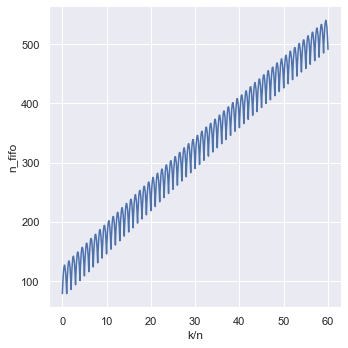

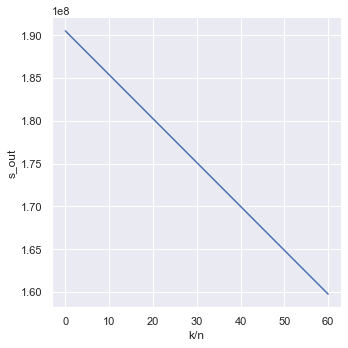

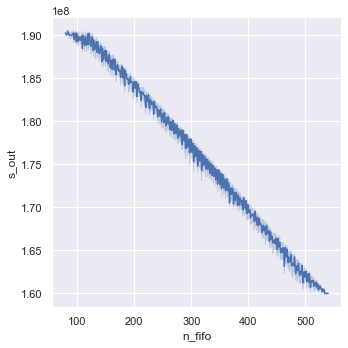

In [14]:
import math
import random
import unittest
import sys
import math
import os
import time
import seaborn as sns
import matplotlib
import pandas as pd

from clock import Clock
from fifo import Fifo, FifoEmpty
from sdram import Sdram

BL = 8
S_IN = 1600e6 / BL
# T_CK = 1 / 1600e6 * 2
T_CK = 1 / S_IN / 4
T_RCD = 7 * T_CK
T_RP = 7 * T_CK
T_CL = 7 * T_CK
T_CCD = 4 * T_CK
T_RTP = max(4 * T_CK, 7.5e-9)
T_RFC = 350e-9

T_IN = 1 / S_IN
T_SW = math.ceil((T_RTP + T_RP + T_RCD - T_CCD) / T_IN) * T_IN
T_RTI = math.ceil((T_SW + T_RFC) / T_IN) * T_IN
T_REFI = math.floor(7.8e-6 / T_IN) * T_IN

N_NUM = 2000


def show_k_div_n__s_out__n_fifo_relation_plot():
    K = 0
    N = 50
    times = 3000
    d = {'k/n': [], 'n_fifo': [], "s_out": []}
    for i in range(times):
        K += 1
        B = math.ceil(K/N)

        S_OUT = (N * T_REFI - K * T_SW - N * T_RTI) / \
            (N * T_REFI) * S_IN  # 64byte

        N_FIFO = math.ceil(
            abs(
                -(B*N - K)*(-B*N + K + N) / N * T_SW * S_IN -
                (T_RTI + B * T_SW) * S_OUT - K / N * T_SW * S_IN
            )
        )

        d['k/n'].append(K/N)
        d['n_fifo'].append(N_FIFO)
        d['s_out'].append(S_OUT)

    df = pd.DataFrame(data=d)

    sns.set_theme()
    sns.relplot(data=df, x='k/n', y='n_fifo', kind="line")
    sns.relplot(data=df, x='k/n', y='s_out', kind="line")
    sns.relplot(data=df, x='n_fifo', y='s_out', kind="line")
    # matplotlib.pyplot.show()

show_k_div_n__s_out__n_fifo_relation_plot()

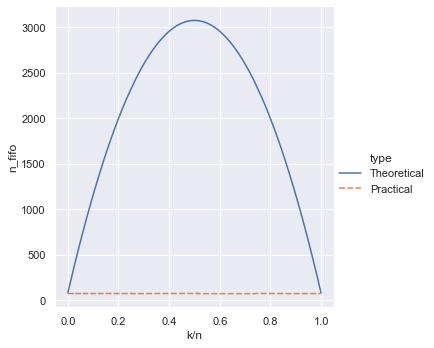

In [27]:
def show_real_use_of_n_fifo_plot(t_start = T_RTI, N = 50, times = 3000):
    K = 0
    d = {'k/n': [], 'n_fifo': [], "type": []}
    # type: 1.Theoretical 2.Practical
    for i in range(times):
        K += 1

        B = math.ceil(K/N)
        S_OUT = (N * T_REFI - K * T_SW - N * T_RTI) / \
                (N * T_REFI) * S_IN  # 64byte
        T_SEQ = (N * T_REFI - K * T_SW - N * T_RTI) / K  # sec
        N_SEQ = math.ceil(T_SEQ * S_IN)  # 64byte
        N_FIFO = math.ceil(
            abs(
                -(B*N - K)*(-B*N + K + N) / N * T_SW * S_IN -
                (T_RTI + B * T_SW) * S_OUT - K / N * T_SW * S_IN
            )
        )
        d['k/n'].append(K / N)
        d['n_fifo'].append(N_FIFO)
        d['type'].append("Theoretical")

        n_seq = math.ceil(N_NUM / N_SEQ)
        wfm_64byte_array = [N_SEQ for i in range(n_seq)]
        fifo_in_interval = 1 / S_IN
        fifo_out_interval = 1 / S_OUT

        ddr_sdram = Sdram(wfm_64byte_array)
        fifo = Fifo(N_FIFO)
        clock = Clock(fifo_in_interval, fifo_out_interval,
                      T_REFI, T_SW, T_RTI, t_start)

        n_min = N_FIFO
        while(not ddr_sdram.get_finished_tranfer()):
            clock.run()
            fin = clock.fifo_in_finish()
            ffull = fifo.is_full()
            fout = clock.fifo_out_finish()
            dsw = clock.is_sw()

            if fin and (not ffull):
                ddr_sdram.send_out()
                fifo.receive_in()

                if ddr_sdram.get_in_sw():
                    clock.set_sw()

            if fout:
                fifo.send_out()

            cur_fifo_n = fifo.get_n_64byte_fifo_current()
            n_min = min(cur_fifo_n, n_min)

        d['k/n'].append(K / N)
        d['n_fifo'].append(N_FIFO - n_min)
        d['type'].append("Practical")

    df = pd.DataFrame(data=d)
    sns.set_theme()
    sns.relplot(data=df, x="k/n", y="n_fifo", hue="type", style="type",kind="line")

show_real_use_of_n_fifo_plot(N = 3000)

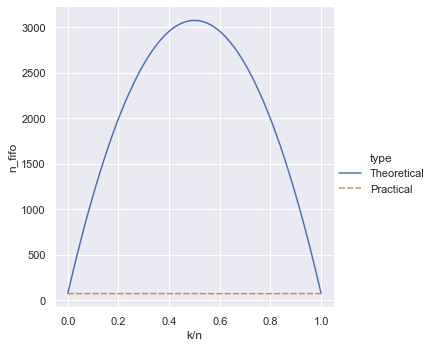

In [28]:
show_real_use_of_n_fifo_plot(T_REFI - T_SW + T_SW / 10000, N = 3000)

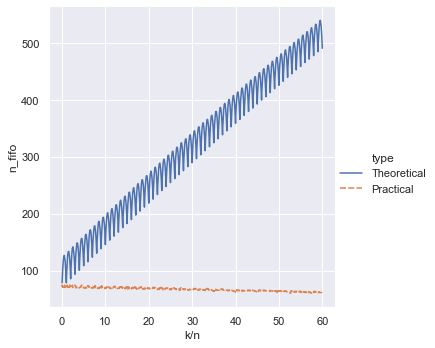

In [29]:
show_real_use_of_n_fifo_plot(T_REFI / 3)

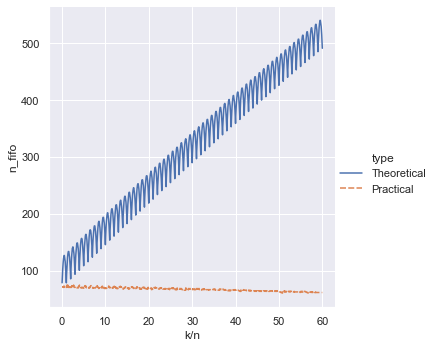

In [30]:
show_real_use_of_n_fifo_plot(T_REFI / 4)

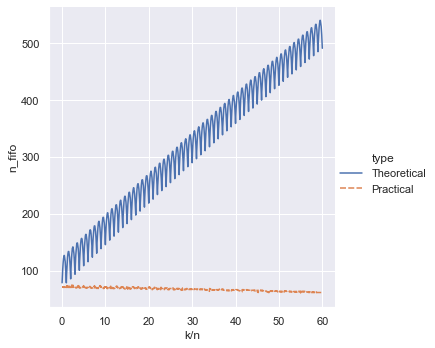

In [31]:
show_real_use_of_n_fifo_plot(T_REFI / 5)

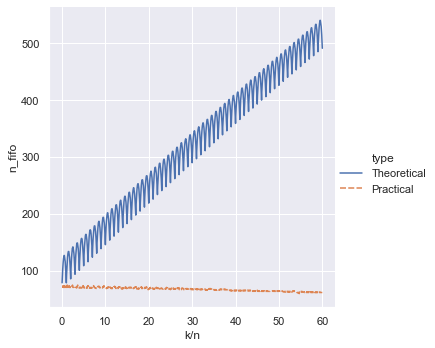

In [32]:
show_real_use_of_n_fifo_plot(T_REFI / 6)

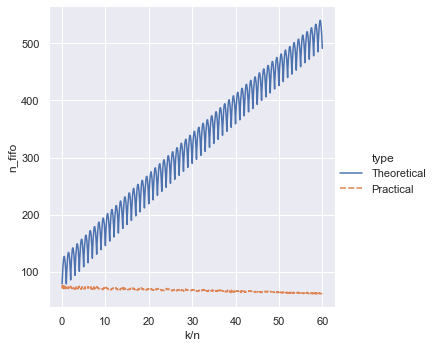

In [26]:
show_real_use_of_n_fifo_plot(T_REFI / 2)

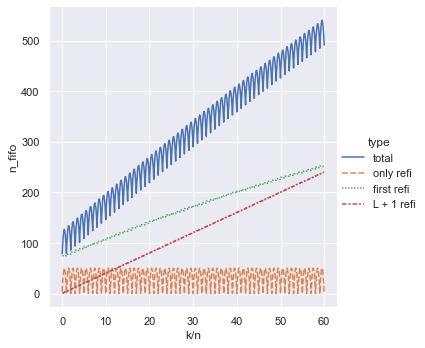

In [5]:
def show_k_div_n__s_out__n_fifo_relation_plot1():
    K = 0
    N = 50
    times = 3000
    d = {'k/n': [], 'n_fifo': [], "s_out": [], "type": []}
    for i in range(times):
        K += 1
        B = math.ceil(K/N)

        S_OUT = (N * T_REFI - K * T_SW - N * T_RTI) / \
            (N * T_REFI) * S_IN  # 64byte

        N_FIFO = math.ceil(
            abs(
                -(B*N - K)*(-B*N + K + N) / N * T_SW * S_IN -
                (T_RTI + B * T_SW) * S_OUT - K / N * T_SW * S_IN
            )
        )

        N_FIFO1 = math.ceil(
            abs(
                -(B*N - K)*(-B*N + K + N) / N * T_SW * S_IN 
            )
        )

        N_FIFO2 = math.ceil(
            abs(
                (T_RTI + B * T_SW) * S_OUT  
            )
        )

        N_FIFO3 = math.ceil(
            abs(
                K / N * T_SW * S_IN
            )
        )

        d['k/n'].append(K/N)
        d['n_fifo'].append(N_FIFO)
        d['s_out'].append(S_OUT)
        d['type'].append("total")

        d['k/n'].append(K/N)
        d['n_fifo'].append(N_FIFO1)
        d['s_out'].append(S_OUT)
        d['type'].append("only refi")

        d['k/n'].append(K/N)
        d['n_fifo'].append(N_FIFO2)
        d['s_out'].append(S_OUT)
        d['type'].append("first refi")

        d['k/n'].append(K/N)
        d['n_fifo'].append(N_FIFO3)
        d['s_out'].append(S_OUT)
        d['type'].append("L + 1 refi")

    df = pd.DataFrame(data=d)

    sns.set_theme()
    sns.relplot(data=df, x='k/n', y='n_fifo', hue="type",style="type", kind="line")

show_k_div_n__s_out__n_fifo_relation_plot1()

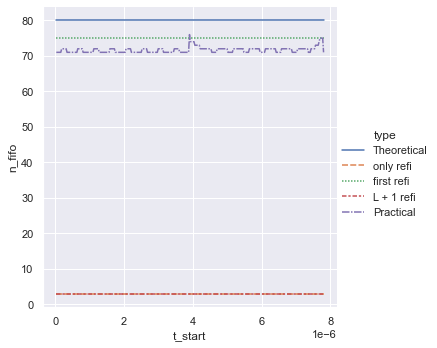

In [19]:
def show_different_t_start_plot(K, N, times=300):
    interval = T_REFI / times

    B = math.ceil(K/N)
    S_OUT = (N * T_REFI - K * T_SW - N * T_RTI) / \
                (N * T_REFI) * S_IN  # 64byte
    T_SEQ = (N * T_REFI - K * T_SW - N * T_RTI) / K  # sec
    N_SEQ = math.ceil(T_SEQ * S_IN)  # 64byte
    N_FIFO = math.ceil(
        abs(
            -(B*N - K)*(-B*N + K + N) / N * T_SW * S_IN -
            (T_RTI + B * T_SW) * S_OUT - K / N * T_SW * S_IN
        )
    )

    n_seq = math.ceil(N_NUM / N_SEQ)
    wfm_64byte_array = [N_SEQ for i in range(n_seq)]
    fifo_in_interval = 1 / S_IN
    fifo_out_interval = 1 / S_OUT

    d = {'t_start': [], 'n_fifo': [], "type": []}
    # type: 1.Theoretical 2.Practical

    t_start = 0
    for i in range(times):
        t_start += interval
        
        N_FIFO1 = math.ceil(
            abs(
                -(B*N - K)*(-B*N + K + N) / N * T_SW * S_IN 
            )
        )

        N_FIFO2 = math.ceil(
            abs(
                (T_RTI + B * T_SW) * S_OUT  
            )
        )

        N_FIFO3 = math.ceil(
            abs(
                K / N * T_SW * S_IN
            )
        )

        d['t_start'].append(t_start)
        d['n_fifo'].append(N_FIFO)
        d['type'].append("Theoretical")

        d['t_start'].append(t_start)
        d['n_fifo'].append(N_FIFO1)
        d['type'].append("only refi")

        d['t_start'].append(t_start)
        d['n_fifo'].append(N_FIFO2)
        d['type'].append("first refi")

        d['t_start'].append(t_start)
        d['n_fifo'].append(N_FIFO3)
        d['type'].append("L + 1 refi")


        ddr_sdram = Sdram(wfm_64byte_array)
        fifo = Fifo(N_FIFO)
        clock = Clock(fifo_in_interval, fifo_out_interval,
                      T_REFI, T_SW, T_RTI, t_start)

        n_min = N_FIFO
        while(not ddr_sdram.get_finished_tranfer()):
            clock.run()
            fin = clock.fifo_in_finish()
            ffull = fifo.is_full()
            fout = clock.fifo_out_finish()
            dsw = clock.is_sw()

            if fin and (not ffull):
                ddr_sdram.send_out()
                fifo.receive_in()

                if ddr_sdram.get_in_sw():
                    clock.set_sw()

            if fout:
                fifo.send_out()

            cur_fifo_n = fifo.get_n_64byte_fifo_current()
            n_min = min(cur_fifo_n, n_min)

        d['t_start'].append(t_start)
        d['n_fifo'].append(N_FIFO - n_min)
        d['type'].append("Practical")

    df = pd.DataFrame(data=d)
    sns.set_theme()
    sns.relplot(data=df, x="t_start", y="n_fifo", hue="type", style="type",kind="line")

show_different_t_start_plot(2, 3)

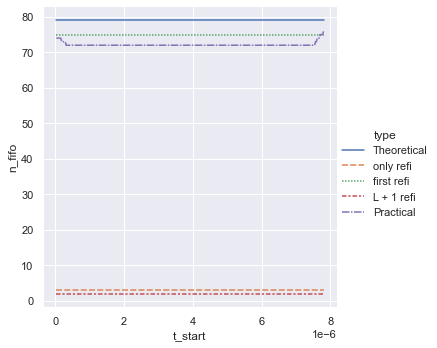

In [23]:
show_different_t_start_plot(1, 3)

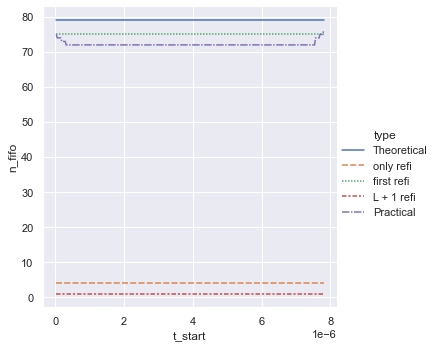

In [25]:
show_different_t_start_plot(1, 44)

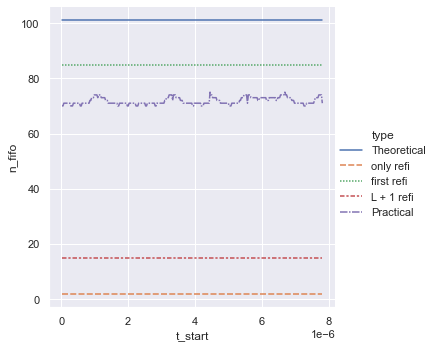

In [20]:
show_different_t_start_plot(7, 2)

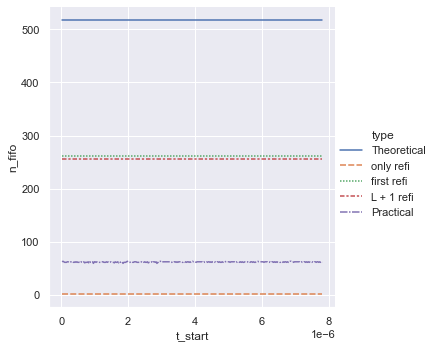

In [21]:
show_different_t_start_plot(127, 2)

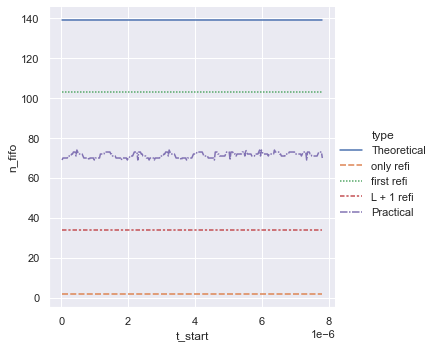

In [22]:
show_different_t_start_plot(17, 2)